# Advanced Data Manipulation II: "I Love Group-By"

In this lecture, we'll work on some additional skills for manipulating and analyzing tabular data. Our focus will be on: 

- **Filtering** data, identifying specific rows according to complex criteria. 
- **Aggregating** data, computing complicated summaries of groups. 

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns

Let's start by reading in some data. Then, we write a function to do data manipulation. 

In [58]:
interval = "2011-2020"
url = f"https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/01_Visualization/decades/{interval}.csv"
time = pd.read_csv(url)

countries_url = "https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/01_Visualization/fips-10-4-to-iso-country-codes.csv"
countries = pd.read_csv(countries_url)

In [59]:
def df_processing(df, country):
    
    
    df["FIPS 10-4"] = df["ID"].str[0:2]
    df1 = pd.merge(df, countries, on = ["FIPS 10-4"])
    df1 = df1.drop(["FIPS 10-4", "ISO 3166"], axis = 1)
    
    df1 = df1.set_index(keys=["ID", "Year", "Name"])
    df1 = df1.stack()
    df1 = df1.reset_index()
    df1 = df1.rename(columns = {"level_3"  : "Month" , 0 : "Temp"})
    df1["Month"] = df1["Month"].str[5:].astype(int)
    df1["Temp"] = df1["Temp"] / 100
    
    df1["Date"] = df1["Year"].astype(str) + "-" + df1["Month"].astype(str)
    df1["Date"] = pd.to_datetime(df1["Date"])
    
    return df1

In [60]:
df = df_processing(time, countries)
df

,ID,Year,Name,Month,Temp,Date
0,ACW00011604,2011,Antigua and Barbuda,1,-0.83,2011-01-01
1,ACW00011604,2011,Antigua and Barbuda,2,-1.32,2011-02-01
2,ACW00011604,2011,Antigua and Barbuda,3,2.78,2011-03-01
3,ACW00011604,2011,Antigua and Barbuda,4,10.40,2011-04-01
4,ACW00011604,2011,Antigua and Barbuda,5,12.13,2011-05-01
...,...,...,...,...,...,...
1504985,ZI000067983,2016,Zimbabwe,5,16.92,2016-05-01
1504986,ZI000067983,2016,Zimbabwe,6,16.81,2016-06-01
1504987,ZI000067983,2016,Zimbabwe,8,18.28,2016-08-01
1504988,ZI000067983,2016,Zimbabwe,10,23.34,2016-10-01


## Grouped Summaries

We already know how to compute grouped summaries of the data using `pd.groupby().aggregate()`. For example, let's compute the mean temperature for each station within each month, averaged across years. Let's also compute the standard deviation and the number of observations. 

In [88]:
df.groupby(["ID", "Month"])["Temp"].aggregate([np.mean, np.std, len])

mean       std  len
ID          Month                          
ACW00011604 1      -0.220000  1.242860    3
            2      -1.076667  0.212211    3
            3       2.740000  3.200187    3
            4       7.603333  2.435371    3
            5      12.890000  1.074802    2
...                      ...       ...  ...
ZI000067983 8      18.333333  0.264071    3
            9      20.322000  0.680823    5
            10     21.562000  1.526866    5
            11     22.606000  0.364527    5
            12     22.582500  1.145815    4

[193845 rows x 3 columns]

This is handy information, and it's convenient to be able to easily collect it in a summary table. However, there are some cases in which we may wish to compute new columns without creating a smaller summary table. 

If you suggested that we merge the summary table from above to our original df, that would eventually work! But merge is a slow operation, and we can actually avoid it by using what are sometimes called window functions. A window function operates on grouped data, without reducing the length of the data frame. In pandas, the most general way to create window functions is by using the transform() method of data frames and series. For example:

In [89]:
# compute the average temperature in each month for each station
# notice the length of the result! 
df.groupby(["ID", "Month"])["Temp"].transform(np.mean)

0          -0.220000
1          -1.076667
2           2.740000
3           7.603333
4          12.890000
             ...    
1504985    17.942000
1504986    16.558000
1504987    18.333333
1504988    21.562000
1504989    22.582500
Name: Temp, Length: 1504990, dtype: float64

Compare this to:

In [90]:
# note the length! 
df.groupby(["ID", "Month"])["Temp"].aggregate(np.mean)

ID           Month
ACW00011604  1        -0.220000
             2        -1.076667
             3         2.740000
             4         7.603333
             5        12.890000
                        ...    
ZI000067983  8        18.333333
             9        20.322000
             10       21.562000
             11       22.606000
             12       22.582500
Name: Temp, Length: 193845, dtype: float64

## Temperature Anomaly Detection

Suppose we'd like to construct a list of unusually hot or cold months in our data set. For example, if February in 1995 is much warmer than average, we'd like to detect this. What makes a month "unusually hot or cold"? There are lots of valid ways to define this. How would you approach this? 

<br>

For our first attempt, let's ask the following idea: 

> For each temperature reading, how does that reading compare to the average reading *in that month* and *at that measurement station*?

For example, if July in 2017 at Zimbabwe was much warmer than the average July reading at that country, then we might say that July 2017 was anomalous. 

### Z-Scores

To make this concrete, let's say that a given month in a year is anomalous if it is more than two standard deviations away from the mean for that month. If you've taken a statistics class, this is the same as requiring that the *z-score* for that month is larger than 2 in absolute value. That is, we should compute:

$$z = \frac{\text{reading} - \text{average reading at station in month}}{\text{standard deviation at station in month}}$$

and ask whether $|z| > 2$. 

How to compute this? Well, we already know how to compute means and standard deviations using methods like our table above, but it's hard to make comparisons to individual months this way. Can you think of how you would perform such a computation in Python? 

<br>
Let's use the `transform()` function.

In [64]:
def z_score(x):
    m = np.mean(x)
    s = np.std(x)
    return (x - m)/s

Now we can compute the z-scores in one shot:

In [91]:
df["z"] = df.groupby(["ID", "Month"])["Temp"].transform(z_score)
df

,ID,Year,Name,Month,Temp,Date,z
0,ACW00011604,2011,Antigua and Barbuda,1,-0.83,2011-01-01,-0.601109
1,ACW00011604,2011,Antigua and Barbuda,2,-1.32,2011-02-01,-1.404366
2,ACW00011604,2011,Antigua and Barbuda,3,2.78,2011-03-01,0.015308
3,ACW00011604,2011,Antigua and Barbuda,4,10.40,2011-04-01,1.406440
4,ACW00011604,2011,Antigua and Barbuda,5,12.13,2011-05-01,-1.000000
...,...,...,...,...,...,...,...
1504985,ZI000067983,2016,Zimbabwe,5,16.92,2016-05-01,-1.434273
1504986,ZI000067983,2016,Zimbabwe,6,16.81,2016-06-01,0.869193
1504987,ZI000067983,2016,Zimbabwe,8,18.28,2016-08-01,-0.247357
1504988,ZI000067983,2016,Zimbabwe,10,23.34,2016-10-01,1.301925


Using transform, we can skip both computing the summary table and merging it later. We're now ready to find anomalous months in our data.

In [92]:
anomalies = df[np.abs(df["z"]) > 2]
anomalies

,ID,Year,Name,Month,Temp,Date,z
45,AE000041196,2011,United Arab Emirates,12,19.05,2011-12-01,-2.270714
49,AE000041196,2013,United Arab Emirates,5,30.95,2013-05-01,-2.255963
69,AE000041196,2015,United Arab Emirates,2,22.21,2015-02-01,2.304883
83,AE000041196,2016,United Arab Emirates,4,26.37,2016-04-01,-2.163684
185,AEM00041194,2011,United Arab Emirates,12,21.36,2011-12-01,-2.142803
...,...,...,...,...,...,...,...
1504741,ZI000067775,2016,Zimbabwe,3,22.15,2016-03-01,2.031115
1504743,ZI000067775,2016,Zimbabwe,5,15.00,2016-05-01,-2.165869
1504761,ZI000067775,2017,Zimbabwe,11,20.72,2017-11-01,-2.102394
1504792,ZI000067964,2011,Zimbabwe,8,15.60,2011-08-01,-2.129303


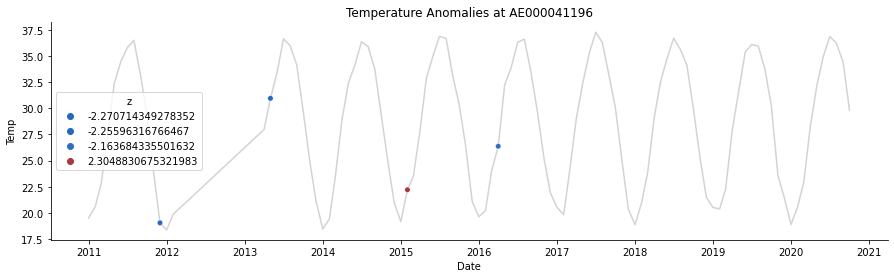

In [93]:
station = "AE000041196"

fig = plt.subplots(figsize = (15, 4))

sns.lineplot(data = df[df["ID"] == station], 
             x = "Date", 
             y = "Temp",
             color = "lightgrey")

sns.scatterplot(data = anomalies[anomalies["ID"] == station], 
                x = "Date", 
                y = "Temp", 
                zorder = 100, # show the dots on top
                hue = "z",
                s = 30, 
                palette = "vlag")

plt.gca().set(title = f"Temperature Anomalies at {station}")
sns.despine()